***Dog breed classication using aws sagemaker***


**Introduction**: Using AWS Sagemaker to finetune a pretrained model that can perform image classification on Dog breed classification problem to classify between different breeds of dogs in images, using Sagemaker profiling, debugger, hyperparameter tuning and many other things



This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [74]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import smdebug
import matplotlib.pyplot as plt
import random
import os
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-01-31 22:45:09--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.104
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  31.1MB/s    in 25s     

2023-01-31 22:45:45 (43.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

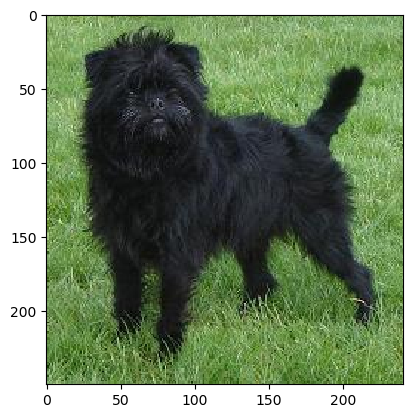

In [81]:
imgpath = random.sample(os.listdir('dogImages/train/001.Affenpinscher'),1)[0]
imgpath = f'dogImages/train/001.Affenpinscher/{imgpath}'
img = plt.imread(imgpath)
plt.imshow(img)
plt.show()

In [3]:
# Upload data to s3
bucket= 'sagemaker-us-east-1-759186667567'
print(f"S3 Bucket: {bucket}")

region = 'us-east-1'
print(f"AWS Region: {region}")

role = get_execution_role()
print("RoleArn: {role}")

S3 Bucket: sagemaker-us-east-1-759186667567
AWS Region: us-east-1
RoleArn: {role}


In [16]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-759186667567/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-759186667567/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://sagemaker-us-east-1-759186667567/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://sagemaker-us-east-1-759186667567/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-759186667567/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg to s3://sagemaker-us-east-1-759186667567/dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg
upload: dogImages/test/001

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "dogImages"

role = sagemaker.get_execution_role()

input_data = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

In [6]:
print("input spec (in this case, just an S3 path): {}".format(input_data))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-759186667567/dogImages


In [24]:
input_data = 's3://sagemaker-us-east-1-759186667567/dogImages'

In [31]:
# Imports Hyperparameters can have continuous values like the learning rate, categorical values like the batch size, 
# and integer values like the number of epochs

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,)


#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    # "epochs": IntegerParameter(2, 4)
}

# Logging Training Results
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [32]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.m5.large",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs = 2,
    max_parallel_jobs = 2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [33]:
# TODO: Fit your HP Tuner
tuner.fit({"training": input_data},wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................................................................!


In [34]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()



2023-02-01 13:22:58 Starting - Preparing the instances for training
2023-02-01 13:22:58 Downloading - Downloading input data
2023-02-01 13:22:58 Training - Training image download completed. Training in progress.
2023-02-01 13:22:58 Uploading - Uploading generated training model
2023-02-01 13:22:58 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'lr': '0.006272548584758591',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2023-02-01-13-03-57-436"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-759186667567/dog-breed-classification-hpo-2023-02-01-13-03-57-436/source/sourcedir.tar.gz"'}

In [30]:
hyperparameters= {'batch_size': 32, 'lr': '0.006272548584758591'}
hyperparameters

{'batch_size': 32, 'lr': '0.006272548584758591'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [25]:
# Import packages
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

In [26]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "10"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}, collection_configs=collection_configs)


In [31]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    entry_point="train_model.py",
    framework_version="1.8.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)


estimator.fit({'train' : input_data },wait=True)


2023-02-01 18:27:35 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-02-01 18:28:35 Starting - Preparing the instances for training......
2023-02-01 18:29:36 Downloading - Downloading input data.........
2023-02-01 18:31:03 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-01 18:31:12,785 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-01 18:31:12,787 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-01 18:31:12,797 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-01 18:31:12,800 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-01 18:31:12,971 sagemaker-training-tool

In [32]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import os
import IPython

[2023-02-01 19:29:13.980 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19781 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [33]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2023-02-01-18-27-35-180
Region: us-east-1


In [34]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

[2023-02-01 19:29:18.858 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19781 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-759186667567/pytorch-training-2023-02-01-18-27-35-180/debug-output
[2023-02-01 19:29:21.174 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19781 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-01 19:29:22.193 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19781 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_i

In [35]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-759186667567/pytorch-training-2023-02-01-18-27-35-180/rule-output


In [36]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

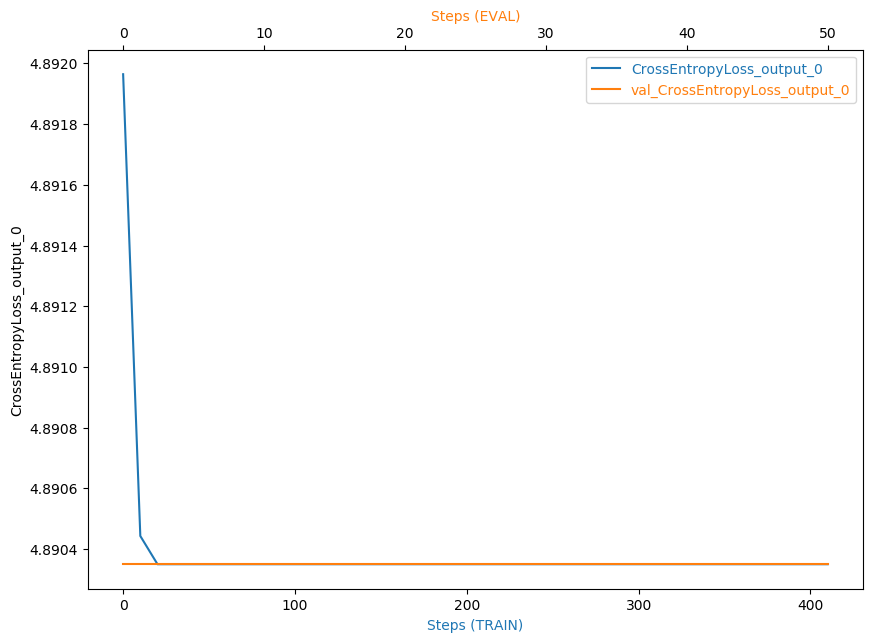

In [38]:
# TODO: Plot a debugging output.
tensor_name = "CrossEntropyLoss_output_0"
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, tensor_name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
There is anomalous behaviour as the line should be smooth line decrease by increasing steps in the debugger report. 

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [40]:
# TODO: Display the profiler output
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [41]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [43]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [44]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [54]:
model_location = 's3://sagemaker-us-east-1-759186667567/pytorch-training-2023-02-01-18-27-35-180/output/model.tar.gz'

In [55]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)
predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.m5.xlarge")

-----!

In [63]:
from PIL import Image
import io
# TODO: Run an prediction on the endpoint
with open("./Alaskan_malamute_00330.jpg", "rb") as f:
    payload = f.read()
    
type(payload)

bytes

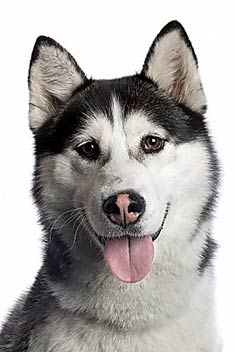

In [64]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [65]:
# TODO: Run an prediction on the endpoint

response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()